# SMD-Übungszettel Nr. 5

Abgabe von: __Pape, Kusurmann und Becker__

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import collections
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

np.random.seed(0)

$\newcommand{\tens}[1]{\underline{\underline{#1}}}$

## Aufgabe 13

### Aufgabenteil a)

$$
\Phi = \Phi_0 E^{-\gamma}
$$
Bestimme zunächst die Transformationsformel.
Zunächst die Normierung $\Phi_0$:

$$\begin{aligned} 
1&=\int_{E_0}^{\infty} \Phi \, \mathrm{d}E\\
&=\frac{\Phi_0}{\gamma+1}E_0^{-\gamma+1} \\
\Leftrightarrow \quad \Phi_0&=(\gamma+E_0^{\gamma-1})
\end{aligned}$$

Nun die Transformationsformel $T(u)$:

$$\begin{aligned}
F(E)&=\int_{E_0}^{E} \Phi \, \mathrm{d}E' \\
&=\frac{-\Phi_0}{\gamma+1}\left( E^{-\gamma+1} - E_0^{-\gamma+1}\right) \overset{!}{=}u\\
\Leftrightarrow \quad T(u)=E&=\left(-\frac{\gamma+1}{\Phi_0}u + E_0^{-\gamma+1}\right)^{\frac{1}{1-\gamma}} {=} \left((-u+1)E_0^{-\gamma + 1}\right)^{\frac{1}{1-\gamma}}
\end{aligned}$$

In [2]:
def transformation(random_number, gamma, E_0, A=1):
    return ( (-random_number + 1) * E_0 ** (-gamma + 1))**(1 / (1 - gamma))

In [3]:
uniform_random = np.random.uniform(size=int(1e5))
gamma = 2.7
E_0 =  1

random_flux = transformation(uniform_random, gamma, E_0)

Darstellung der erstellten Zufalsszahlen in einem Histogramm.
Die leeren Bins werden wahrscheinlich durch die geringe Anzahl an Zufallszahlen hervorgerufen.

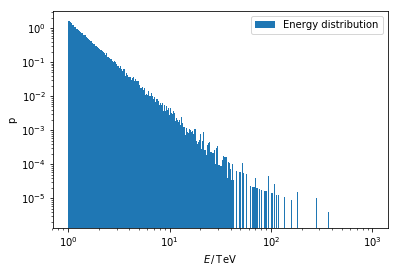

In [8]:
plt.hist(random_flux, density=True,
         bins=np.logspace(0, 3, 1000), label='Energy distribution');

plt.xlabel(r'$E\,/\,\mathrm{TeV}$')
plt.ylabel('p')
plt.yscale('log')
plt.xscale('log')
plt.legend();

Komischer Weise ist $p>1$.

Abspeichern in Dataframe.

In [5]:
df = pd.DataFrame(data={'Energy':random_flux})

### Aufgabenteil b)

In [6]:
def detector_probability(E):
    return (1 - np.exp(-E/2))**3

In [7]:
yrandom = np.random.uniform(0, 1, int(1e5))

df['AcceptanceMask']=(yrandom<=detector_probability(random_flux))

Text(0.5, 1.0, 'Energy distribution before and after considering the detector tolerance.')

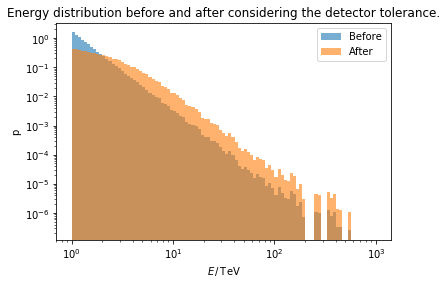

In [8]:
plt.hist(random_flux, density=True,
         bins=np.logspace(0, 3, 100),
         alpha=0.6, label='Before');

plt.hist(random_flux[df['AcceptanceMask'].values], density=True,
         bins=np.logspace(0, 3, 100), alpha=0.6, label='After')

plt.xlabel(r'$E\,/\,\mathrm{TeV}$')
plt.ylabel('p')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Energy distribution before and after considering the detector tolerance.')


Deutlich zuerkenn ist, dass größere Energien mit einer höheren Wahrscheinlichkeit detektiert werden, als kleine Energien.

### Aufgabenteil c)

In [9]:
def hits_polar(E, sigma=1, mu=0):
    
    u_1 = np.random.uniform(size=len(E))
    u_2 = np.random.uniform(size=len(E))

    v_1 = 2 * u_1 - 1
    v_2 = 2 * u_2 - 1
 
    s = (v_1)**2 + (v_2)**2 

    if len(s[s<1]) < len(E):
        
        # Generating new s values as long as the length of s[s<1] is not 
        # equal to E.
        while len(s[s<1]) < len(E):
            u_1 = np.random.uniform(size=int(len(s[s>=1])))
            u_2 = np.random.uniform(size=int(len(s[s>=1])))
            
            # replace varibales with s>=1 with new random variables 
            # to increase the valid numbers of s values
            v_1[s>=1] = 2 * u_1 - 1
            v_2[s>=1] = 2 * u_2 - 1
    
            s = v_1**2 + v_2**2 

        
        cof = np.sqrt( -2 / s * np.log(s))
        
        z_1 = v_1 * cof
        z_2 = v_2 * cof
        
        # transforme a normal standart normal distribution to 
        # a normal distribution with given mu and sigma
        
        x =  sigma * z_1 + mu
        y =  sigma * z_2 + mu
        return x, y
    
    else:
        cof = np.sqrt( -2 / s[s<1] * np.log(s[s<1]))
        z_1 = v_1[s<1] * cof 
        z_2 = v_2[s<1] * cof
        
        # transforme a normal standart normal distribution to 
        # a normal distribution with given mu and sigma
        x =  sigma * z_1 + mu
        y =  sigma * z_2 + mu
        
        return z_1, z_2 

In [10]:
x, y = hits_polar(random_flux, sigma=2*random_flux,
                  mu=10*random_flux)

Verwende die Variabele `x` als Wert für Hits.

In [11]:
df['NumberOfHits'] = x.astype('int')

### Aufgabenteil d)

In [12]:
def sigma_position(hits):
    return 1 / np.log10( hits + 1)

In [13]:
mu_x = 7
mu_y = 3

x_position = np.random.normal(mu_x,
                              sigma_position(df['NumberOfHits'].values))

y_position = np.random.normal(mu_y,
                              sigma_position(df['NumberOfHits'].values))

In [14]:
df['x'] = x_position
df['y'] = y_position

### Aufgabenteil e)

In [15]:
def hit_noise(number, mu, sigma):
    return 10 * np.exp(np.random.normal(mu, sigma, number)).astype('int')

In [16]:
mu_hits_noise = 2
sigma_hits_noise = 1

hits_noise = hit_noise(int(1e7), mu_hits_noise, sigma_hits_noise)

Mit der unteren Funktion `xy_position_noise` wird auch der sensitive Bereich des Detektors berücksichtigt. Aus diesem Grund wird solange nachgezogen, bis $x^*$ und $y^*$ nur noch im sensitiven Bereich liegen. Ist einem die Anzahl an Datenpunkte mehr oder weniger egal, können alternative die $x^*$ und $y^*$ weggeschnitten werden, die nicht im sensitiven Bereich liegen. Dieses Vorgehen effiziert aber eine ungleiche Länge von $x^*$ und $y^*$, welche auch durch weiteres rauschneiden korrigiert werden könnte.

In [17]:
def xy_position_noise(number, xmu, ymu, sigma, rho, xgeometry, ygeometry):
    # I could use here the polar method as well 
    x = np.random.normal(size=number)
    y = np.random.normal(size=number)
    
    x_star = np.sqrt(1 - rho**2) * sigma * x + rho * sigma * y + xmu
    y_star = sigma * y + ymu
    
    # I create the index variables to make the code readable on the printed
    # jupyter notebook
    
    xindex = (x_star < xgeometry[0]) | (x_star > xgeometry[1])
    while len(x_star[xindex]) != 0:
            x = np.random.normal(size=len(x_star[xindex]))
            y = np.random.normal(size=len(x_star[xindex]))
            
            x_star[xindex] = np.sqrt(1 - rho**2) * sigma * x + rho * sigma * y + xmu   
            xindex = (x_star < xgeometry[0]) | (x_star >= xgeometry[1])
    
    # now for y 
    yindex = (y_star < ygeometry[0]) | (y_star > ygeometry[1])
    
    while len(y_star[yindex]) != 0:
            y = np.random.normal(size=len(y_star[yindex]))
            
            y_star[yindex] = sigma * y + ymu
            
            yindex = (y_star < ygeometry[0]) | (y_star >= ygeometry[1])
    
    return x_star, y_star

In [18]:
sigma_position_noise = 3
rho = 0.5
mu_detector = 5
x_noise, y_noise = xy_position_noise(int(1e7), mu_detector, 
                                     mu_detector, sigma_position_noise, rho, 
                                     xgeometry=(0, 10), ygeometry=(0,10))

Plotte die $x$ und $y$ Positionen des Noise.

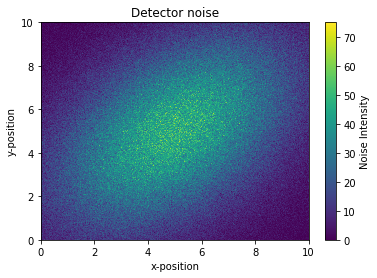

In [19]:
plt.hist2d(x_noise, y_noise, bins=700);

plt.xlabel('x-position')
plt.ylabel('y-position')
plt.title('Detector noise')
plt.colorbar(label='Noise Intensity')

In [20]:
df_noise = pd.DataFrame(data={'NumberOfHits':hits_noise,
                              'x':x_noise, 'y':y_noise})

Speicher die Ergebnisse in `.hdf5` Datei.

In [21]:
df.to_hdf(path_or_buf='./NeutrinoMC.hdf5', key='Signal')
df_noise.to_hdf(path_or_buf='./NeutrinoMC.hdf5', key='Background')

## Aufgabe 14

### Aufgabenteil a)

In [22]:
X, y = make_blobs(n_samples=1000, centers=2,
                  n_features=4, random_state=0)

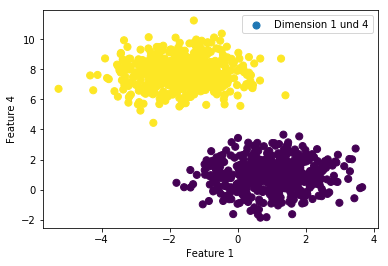

In [23]:
plt.scatter(X[:, 0], X[:, 3], c=y, s=50,
            label='Dimension 1 und 4')

plt.xlabel('Feature 1')
plt.ylabel('Feature 4')
plt.legend()

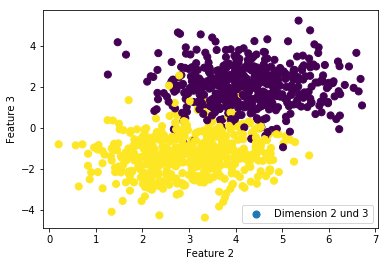

In [24]:
plt.scatter(X[:, 1], X[:, 2], c=y, s=50,
            label='Dimension 2 und 3')

plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.legend()

### Aufgabenteil b)

Die *Hauptkomponentenanalyse* zielt darauf ab die Dimension des Problems zu verringern.
Durch die Verringerung soll die Anzahl an redundanten Daten minimiert werden. 
Hierzu sollen mit Hilfe von Hauptachsentransformationen die Datenpunkte linear unabhängig dargestellt werden und somit getrennt werden. 

Betrachte eine Datenmenge $x\in\mathbb{K}^{d}$ 

__Funktionsweise:__

1. Berchene die Differenz $x'=x-\mu$ mit $\mu\in\mathbb{K}^{d}$. Hiermit werden die die Datenpunkte auf den Mittelpunkt zentriert. 

2. Berechne die Kovarianzmatrix: $\mathbf{Cov(x)} = E\left(x' x'^{\intercal}\right)\in\mathbb{K}^{d\times d}$

3. Berechne die Eigenwerte $\lambda_i\in\mathbb{K}$ und Eigenvektoren $v_i\in\mathbb{K}^{d}$ der Kovarianzmatrix. 

4. Für $\lambda_i\in\mathbb{R}$ sotiere die Eigenwerte nach ihrer Größe $\lambda_1 > \lambda_2 > \dots > \lambda_d$. Abhängig von der Zahl der Dimensionen $k$ die mein Endproblem besitzen sollen, nehme ich die dazugehörigen Eigenwerte und -vektoren. Hierbei werden immer die Eigenwerte von groß nach klein gewählt. Beispiel: Möchte ich das mein Problem abschließend die Dimension drei besitzt, verwende ich die Eigenwerte $\lambda_1, \lambda_2$ und $\lambda_3$ (und die dazugehörien Eigenvektoren).

5. Schreibe die Eigenvektoren in die Transformationsmatrix $\mathbf{W}=(v_1, v_2, \dots, v_k)\in\mathbb{R}^{k\times d}$.

6. Abschließend werden die Datenpunkte in der Datenmatrix $\mathbf{X}$ transformiert:
$\mathbf{X'}=\mathbf{W}\mathbf{X}$ und so eine Reduktion auf $k$ Dimensionen durchgeführt.

### Aufgabenteil c)

In [25]:
pca = PCA(n_components=4)

transformed = pca.fit_transform(X)
eigenvalues = pca.explained_variance_

print(f'Eigenwerte der Kovarianzmatrix: {eigenvalues}')

Eigenwerte der Kovarianzmatrix: [17.51933024  0.99958442  0.98813673  0.89875061]


Auffällig bei den Eigenwerten ist, dass der erste Eigenwert deutlich größer ist, als die die anderen drei. Anscheindend enthält das erste Feature die meisten Inforamtionen und die restlichen drei kaum zusätzliche Informationen. Dieses Resultat kann zusätzlich mit der 
der eingebauten Funktion `explained_variance_ratio_` bestätigt werden. Die Funktion gibt an wie viel Information in dem Eigenwert enthalten ist:

In [26]:
pca.explained_variance_ratio_

array([0.85854652, 0.0489853 , 0.0484243 , 0.04404388])

Es zeigt sich das der erste Eigenwert $85\%$ der Information enthält und die anderen drei jweils nur etwa $5\%$.

In [27]:
pca.get_covariance()

array([[ 2.62583302,  0.80302067,  2.12234349, -4.3783228 ],
       [ 0.80302067,  1.33533433,  1.09428645, -2.18876646],
       [ 2.12234349,  1.09428645,  3.69087992, -5.66291375],
       [-4.3783228 , -2.18876646, -5.66291375, 12.75375474]])

Die Kovarianzmatirx zeigt weiterhin das die Verteilung bzw. das Feature $4$ sich deutlich von den anderen Features abgrenzt. Somit lassen sich die Verteilung anscheindend eindeutig charakterisieren. Diese Eigenschaft zeigt sich auch in den `scatter` Plots.

### Aufgabenteil d)

Text(0, 0.5, 'Count')

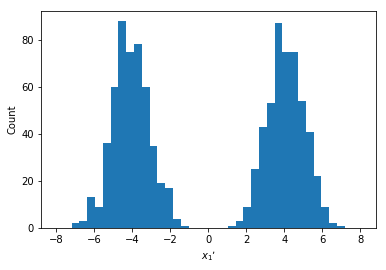

In [28]:
# Erstes Feature
plt.hist(transformed[:,0], bins=np.linspace(-8, 8, 40));

plt.xlabel(r'$x_1’$')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

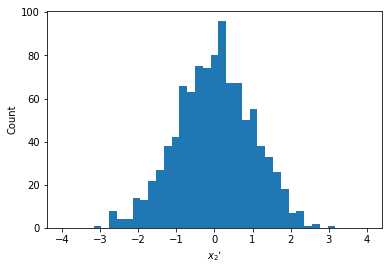

In [29]:
# Zweites Feature
plt.hist(transformed[:,1], bins=np.linspace(-4, 4, 40));

plt.xlabel(r'$x_2’$')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

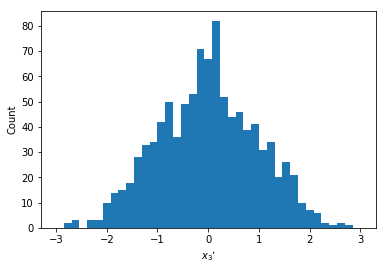

In [30]:
# Drittes Feature
plt.hist(transformed[:,2], bins=np.linspace(-3, 3, 40));

plt.xlabel(r'$x_3’$')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

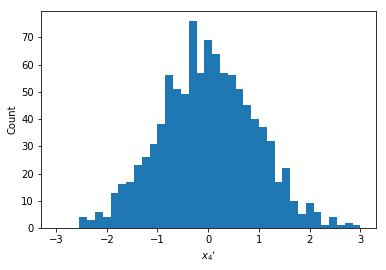

In [31]:
# Viertes Feature
plt.hist(transformed[:,3], bins=np.linspace(-3, 3, 40));

plt.xlabel(r'$x_4’$')
plt.ylabel('Count')

Deutlich zu erkennen ist, dass das erste Feature zwei verschiedene Verteilung hervorbringt. 


Text(0, 0.5, '$x_2’$')

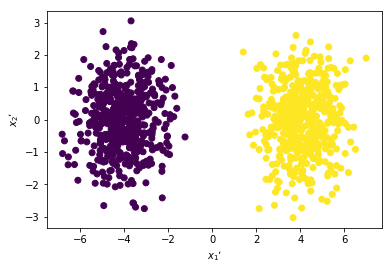

In [32]:
plt.scatter(transformed[:,0],transformed[:,1], c=y)

plt.xlabel(r'$x_1’$')
plt.ylabel(r'$x_2’$')

Das Feature $x_1'$ sorgt somit für eine eindeutige Trennung des Datensatzes.
Hierbei ist die Trennung unabhängig von den anderen Features. 
Beim Vergleich mit zum Beispiel $x_3'$ ist das nicht der Fall.

Text(0, 0.5, '$x_2’$')

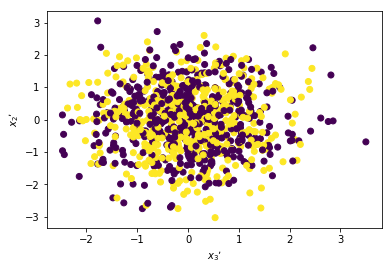

In [33]:
plt.scatter(transformed[:,3],transformed[:,1], c=y)

plt.xlabel(r'$x_3’$')
plt.ylabel(r'$x_2’$')